# Calculation results 

Via C code a LUT was generated 

```
/**
 * Reflects the lower bits of a value.
 *
 * @param val The value to reflect.
 * @param num_bits The number of lower bits to reflect.
 * @return The reflected value.
 */
uint32_t reflect(uint32_t val, int num_bits)
{
    uint32_t result = 0;
    for (int i = 0; i < num_bits; i++)
    {
        if (val & (1 << i))
            result |= (1 << (num_bits - 1 - i));
    }
    return result;
}

/**
 * Generates a CRC32 lookup table for a given polynomial using reflection.
 *
 * @param crcTable The table to be filled with CRC32 values.
 * @param polynomial The polynomial used for generating the CRC32 values.
 */
void generate_crc32_table(uint32_t crcTable[CRC_TABLE_SIZE], uint32_t polynomial)
{
    polynomial = reflect(polynomial, 32); // Reflect the polynomial
    for (uint32_t i = 0; i < CRC_TABLE_SIZE; i++)
    {
        uint32_t crc = reflect(i, 8); // Reflect the input byte
        for (uint8_t j = 0; j < 8; j++){
            if (crc & 1){
                crc = (crc >> 1) ^ polynomial;
            }else{
                crc >>= 1;
            }
        }
        crcTable[i] = reflect(crc, 32); // Reflect the result before storing it
    }
}
```

## Rcrc

$$ Rcrc(Pe) = \sum_{i=1}^n{A[i] \cdot Pe^i \cdot (1-Pe)^{n-i}}$$


### Step 5: Detailed Practical Computation

**Parity Check Matrix $H$**

For a linear block code, the parity check matrix $H$ has dimensions $(n-k) \times n$, where $n$ is the total number of bits in each codeword, and $k$ is the number of message bits. The matrix $H$ ensures that for any valid codeword $c$, $Hc^T = 0$.

#### 1. **Binary Vector Operations**

Each row of $H$ represents a constraint that any valid codeword must satisfy. A binary vector operation in this context involves:
- **XOR Operation**: Logical XOR operation between two binary vectors (rows) is defined as:
  $$[v_1 \oplus v_2]_i = v_{1i} \oplus v_{2i} \quad \text{for all } i \text{ from } 1 \text{ to } n$$
  where $v_{1i}$ and $v_{2i}$ are the $i$-th bits of vectors $v_1$ and $v_2$ respectively, and $\oplus$ denotes the XOR operation.

#### 2. **Generating All Row Combinations**

We consider all possible subsets of rows from $H$. The number of such subsets (excluding the empty set) is $2^{n-k} - 1$. For each subset:
- **Subset Selection**: A subset of rows $R \subset \{1, 2, ..., n-k\}$ is selected. The selection can be represented as a binary number where each bit position indicates whether a row is included.
- **Vector Combination**: The corresponding rows are combined using XOR:
  $$v = \bigoplus_{i \in R} H_i$$
  where $H_i$ is the $ i $-th row of $ H $, and $ \bigoplus $ denotes the XOR operation applied across multiple vectors.

#### 3. **Calculating the Weight of Each Vector**

For each resultant vector $v$ from the combination process:
- **Weight Calculation**: The weight $w(v)$ of a vector $v$ is the number of 1's in $v$:
  $$w(v) = \sum_{i=1}^n v_i$$
  where $v_i$ is the $i$-th bit of vector $v$.

#### 4. **Building the Weight Distribution**

For every vector $v$ calculated:
- **Distribution Tallying**: Increase the count of vectors that have weight $w(v)$ in a distribution array $D$ where $D[w]$ represents the number of vectors of weight $w$:
  $$D[w(v)] = D[w(v)] + 1$$
- The array $D$ will be of size $n+1$ to account for all possible weights from 0 to $n$.

### Summary of Formulas and Steps

1. **Vector XOR**: $[v_1 \oplus v_2]_i = v_{1i} \oplus v_{2i}$.
2. **Vector Combination**: $v = \bigoplus_{i \in R} H_i$.
3. **Weight Calculation**: $w(v) = \sum_{i=1}^n v_i$.
4. **Distribution Update**: $D[w(v)] = D[w(v)] + 1$.

These steps will calculate the weight distribution for a parity check matrix, reflecting the number of vectors at each weight level that can arise from different combinations of rows, providing insights into the error detection and correction capabilities of the code.

In [14]:
import numpy as np
from itertools import combinations

import time

def get_single_probability(Pe,i,n,Ai):
    return (Pe**i)*((1-Pe)**(n-i)) * Ai

def get_probability_dual(Pe,i,n,Bi):
    print("TODO: this function might be wrongly implemented")
    # https://sci-hub.yt/10.1109/tcom.1985.1096340
    # page 2 of the paper equation (6)
    
    Rcrc = 0.0 
    for i in range(0,n+1):
        Rcrc += Bi * ( 1 - 2 * Pe )**i - ( 1 - Pe )**n

    Rcrc = Rcrc * 1/(2**(n-k))

    return Rcrc

def get_probability(Pe,n,A):
    Rcrc = 0 

    for i in range(1,n+1):
        Rcrc += get_single_probability(Pe,i,n,A[i-1])
    
    return Rcrc

# will create the [(n-k), n] matrix
def initialize_parity_check_matrix(polynom=0x104C11DB7, n=64, k=32):
    # Calculate number of parity bits as n - k
    rows = n - k
    columns = n

    # Convert polynomial to binary representation, ignoring the highest bit (assumed x^n term)
    poly_bits = [(polynom >> i) & 1 for i in range(columns-1, -1, -1)]
    
    # Initialize matrix H with dimensions (rows, columns)
    H = np.zeros((rows, columns), dtype=int)

    # Set the first row of H based on the polynomial bits
    for i in range(columns):
        H[0, i] = poly_bits[i]

    # Fill the rest of the rows by cyclically shifting the first row
    for i in range(1, rows):
        H[i] = np.roll(H[i-1], 1)  # np.roll shifts elements to the right 
    
    return H

def calculate_weight_distribution(H):
    (rows, cols) = H.shape  # (n-k) x n matrix
    num_subsets = 2 ** rows  # There are 2^(n-k) possible subsets including the empty set
    weight_distribution = np.zeros(cols + 1, dtype=int)  # Max weight is n, indexing from 0 to n

    t0 = time.time()
    # Iterate over all possible subsets (excluding the empty set, starting from 1)
    for subset in range(1, num_subsets):
        combination_vector = np.zeros(cols, dtype=np.uint8)  # Initialize the combination vector

        # Check each row if it should be included in the current subset
        for i in range(rows):
            if subset & (1 << i):  # Check if the ith bit is set in the subset
                # XOR the current combination vector with the ith row of H
                combination_vector = np.bitwise_xor(combination_vector, H[i])

        # Calculate the weight of the combination vector (count of 1's)
        weight = np.sum(combination_vector)
        weight_distribution[weight] += 1  # Update the weight distribution

        if (subset == 5000000):
            t1 = time.time()
            print("Time taken for ", subset, "  subsets:", t1 - t0)
            print("Time left:", (t1 - t0) * (num_subsets - subset)/subset)

            return weight_distribution


    return weight_distribution


# Example usage:
r = 32  # Number of parity bits ... 32 bits for CRC32
k = 32  # Number of message bits
n = k + r # Total number of codeword bits
H = initialize_parity_check_matrix(0x1F1922815, n, k)  # Initialize the parity check matrix

# Calculate the weight distribution for the generated matrix
distribution = calculate_weight_distribution(H)
print("Weight Distribution:", distribution)


Time taken for  5000000   subsets: 166.19545555114746
Time left: 142594.61381164886
Weight Distribution: [     0      0      0      0      0      0      0      0      0      0
      1     28     94    223    733   1994   5104  11647  23524  44807
  79649 129563 196286 279309 365600 443135 504523 533615 523932 480873
 410924 325966 240762 165634 105498  62403  33838  16791   8030   3433
   1328    532    160     45     13      2      1      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0]


In [22]:
import numpy as np
import time

def get_single_probability(Pe, i, n, Ai):
    return (Pe**i) * ((1-Pe)**(n-i)) * Ai

def get_probability(Pe, n, A):
    return sum(get_single_probability(Pe, i, n, A[i-1]) for i in range(1, n+1))

def initialize_parity_check_matrix(polynom=0x1F1922815, n=64, k=32):
    rows = n - k
    poly_bits = np.array([(polynom >> i) & 1 for i in range(n-1, -1, -1)], dtype=int)
    H = np.zeros((rows, n), dtype=int)
    H[0] = poly_bits
    for i in range(1, rows):
        H[i] = np.roll(H[i-1], 1)
    return H

def calculate_weight_distribution(H):
    (rows, cols) = H.shape  # (n-k) x n matrix
    num_subsets = 2 ** rows  # There are 2^(n-k) possible subsets including the empty set
    weight_distribution = np.zeros(cols + 1, dtype=int)  # Max weight is n, indexing from 0 to n

    t0 = time.time()
    # Iterate over all possible subsets (excluding the empty set, starting from 1)
    for subset in range(1, num_subsets):
        combination_vector = np.zeros(cols, dtype=np.uint8)  # Initialize the combination vector

        # Check each row if it should be included in the current subset
        for i in range(rows):
            if subset & (1 << i):  # Check if the ith bit is set in the subset
                # XOR the current combination vector with the ith row of H
                combination_vector = np.bitwise_xor(combination_vector, H[i])

        # Calculate the weight of the combination vector (count of 1's)
        weight = np.sum(combination_vector)
        weight_distribution[weight] += 1  # Update the weight distribution

        if (subset == 50000):
            t1 = time.time()
            print("Time taken for ", subset, "  subsets:", t1 - t0)
            print("Time left:", (t1 - t0) * (num_subsets - subset)/subset)

            return weight_distribution


    return weight_distribution

# Example usage
r, k = 32, 32  # Number of parity and message bits
n = k + r
H = initialize_parity_check_matrix(0x1F1922815, n, k)
'''
print("\nuint64_t H[{}][{}] = \\".format(n-k, n)) 
print("{ \\")
for i in range(n-k):
    print("{", end="")
    for j in range(n):
        print(H[i][j], end="")
        if j != n-1:
            print(", ", end="")
    print("}, \\")

print("};")
'''

distribution = calculate_weight_distribution(H)
print("Weight Distribution:", distribution)


uint64_t H[32][64] = \
{ \
{0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1}, \
{1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0}, \
{0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1}, \
{1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0}, \
{0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0

In [19]:
print("Weight Distribution of CRC32 Parity-Check Matrix:")
for i,w in enumerate(distribution):
    print(f"Weight {i}: {w} combinations")
    
RI = get_probability(0.01, n, distribution)
print(f"RI: {RI}")

Weight Distribution of CRC32 Parity-Check Matrix:
Weight 0: 0 combinations
Weight 1: 0 combinations
Weight 2: 0 combinations
Weight 3: 0 combinations
Weight 4: 0 combinations
Weight 5: 0 combinations
Weight 6: 0 combinations
Weight 7: 0 combinations
Weight 8: 0 combinations
Weight 9: 0 combinations
Weight 10: 6 combinations
Weight 11: 0 combinations
Weight 12: 152 combinations
Weight 13: 0 combinations
Weight 14: 1619 combinations
Weight 15: 0 combinations
Weight 16: 10286 combinations
Weight 17: 0 combinations
Weight 18: 49384 combinations
Weight 19: 0 combinations
Weight 20: 164684 combinations
Weight 21: 0 combinations
Weight 22: 408885 combinations
Weight 23: 0 combinations
Weight 24: 747365 combinations
Weight 25: 0 combinations
Weight 26: 1025283 combinations
Weight 27: 0 combinations
Weight 28: 1050721 combinations
Weight 29: 0 combinations
Weight 30: 806921 combinations
Weight 31: 0 combinations
Weight 32: 459853 combinations
Weight 33: 0 combinations
Weight 34: 197340 combinat

[A_04C11DB7] Rcrc =  [0.00000000e+00 1.71623343e-01 2.66016181e+00 2.66016181e+01
 1.92861732e+02 1.08002570e+03 4.86011563e+03 1.80518581e+04
 5.64120565e+04 1.50432151e+05 3.45993946e+05 6.91987893e+05
 1.21097881e+06 1.86304433e+06 2.52841730e+06 3.03410076e+06
 3.22373206e+06 3.03410076e+06 2.52841730e+06 1.86304433e+06
 1.21097881e+06 6.91987893e+05 3.45993946e+05 1.50432151e+05
 5.64120565e+04 1.80518581e+04 4.86011563e+03 1.08002570e+03
 1.92861732e+02 2.66016181e+01 2.66016181e+00 1.71623343e-01
 5.36322946e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
[A

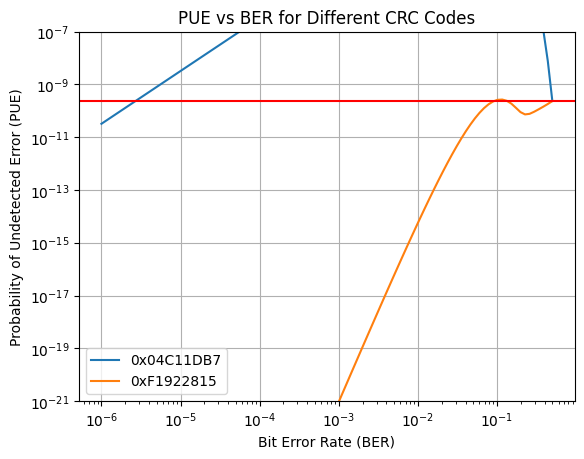

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import math


def get_probability_dual(Pe,i,n,Bi):
    print("TODO: this function might be wrongly implemented")
    # https://sci-hub.yt/10.1109/tcom.1985.1096340
    # page 2 of the paper equation (6)
    
    Rcrc = 0.0 
    for i in range(0,n+1):
        Rcrc += Bi * ( 1 - 2 * Pe )**i - ( 1 - Pe )**n

    Rcrc = Rcrc * 1/(2**(n-k))

    return Rcrc

def get_single_probability(Pe,i,n,Ai):
    return (Pe**i)*((1-Pe)**(n-i)) * Ai

# binominal coefficient calculation
def binom(n_,k_):
  return math.factorial(n_) / (math.factorial(k_) * math.factorial(n_-k_))

#https://sci-hub.yt/https://link.springer.com/chapter/10.1007/978-981-13-3113-8_1
def get_approximation(Pe,d_hamming, r, n):
    data_ = 0 
    for i in range(d,n+1):
        data_ += binom(n,i) * (Pe**i) * ((1-Pe)**(n-i))
    
    return data*1/(2**r)


Pe = 0.01 
n = 64
Rcrc_worst = 1/(2**32)

A_04C11DB7 = np.loadtxt("weight_64bit_04C11DB7.data")
A_F1922815 = np.loadtxt("weight_64bit_F1922815.data")
assert(A_04C11DB7.shape[0] == n)
assert(A_F1922815.shape[0] == n)

Rcrc_A_04C11DB7 = 0.0
Rcrc_A_F1922815 = 0.0
for i in range(1,n):
    p_A_04C11DB7 = get_single_probability(Pe,i,n,A_04C11DB7)
    p_A_F1922815 = get_single_probability(Pe,i,n,A_F1922815)
    Rcrc_A_04C11DB7 += p_A_04C11DB7 
    Rcrc_A_F1922815 += p_A_F1922815

print("[A_04C11DB7] Rcrc = ", Rcrc_A_04C11DB7)
print("[A_F1922815] Rcrc = ", Rcrc_A_F1922815)


Rcrc_list_04C11DB7 = []
Rcrc_list_F1922815 = []
min_pe=1e-6
max_pe=0.5
ber_range = (min_pe, max_pe)
Pe_list = np.logspace(np.log10(ber_range[0]), np.log10(ber_range[1]), num=100)
Pe_list = np.insert(Pe_list, 0, 0.1) #insert at the beginning of the list
Pe_list = np.insert(Pe_list, 0, 0.01) #insert at the beginning of the list
Pe_list = np.insert(Pe_list, 0, 0.001) #insert at the beginning of the list

# sort the list
Pe_list = np.sort(Pe_list)


for e in Pe_list:
    Rcrc_04C11DB7_ = 0.0
    Rcrc_F1922815_ = 0.0
    # Sum from 1 to n means n is includeded
    # hence the range is 1 to n+1
    for i in range(1,n+1):
        p_04C11DB7 = get_single_probability(e,i,n,A_04C11DB7[i-1]) #i-1 because the index starts from 0
        p_F1922815 = get_single_probability(e,i,n,A_F1922815[i-1])
        Rcrc_04C11DB7_ += p_04C11DB7 
        Rcrc_F1922815_ += p_F1922815
    
    if e == 0.01 or e == 0.1 or e == 1e-3:
        print("Pe(",e,") = ", Rcrc_F1922815_)

    Rcrc_list_04C11DB7.append(Rcrc_04C11DB7_)
    Rcrc_list_F1922815.append(Rcrc_F1922815_)



if (np.array(Rcrc_list_F1922815) > Rcrc_worst).any():
    print("There is a case where Rcrc > Rcrc_worst")

#print(Pe_list)
#print(Rcrc_list)

fig, ax = plt.subplots(1,1) #plt.figure(figsize=(10, 6))
#ax.semilogx(ber_values, pue_values, label=f'CRC Length: {crc_length} bits, Hamming Distance: {hamming_distance}')
plt.loglog(Pe_list, Rcrc_list_04C11DB7, label=f'0x04C11DB7')
plt.loglog(Pe_list, Rcrc_list_F1922815, label=f'0xF1922815')
plt.axhline(1/(2**32), color='r')  # Add horizontal line worst case
ax.set_ylim(1e-21,1e-7)
plt.xlabel('Bit Error Rate (BER)')
plt.ylabel('Probability of Undetected Error (PUE)')
plt.title('PUE vs BER for Different CRC Codes')
plt.legend()
plt.grid(True)


